# Реализация нейронной сети для задачи классификации

Нейросеть будет состоять всего из трёх слоёв и два из них будут скрыты.

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True   # хотим, чтобы была воспроизводимость

In [2]:
import sklearn.datasets

# В этом датасете 178 различных бутылок вин, у каждой - 13 различных параметров
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2],   # используем первые 2 колонки для ужобства визуализации
    wine.target,
    test_size=0.3,
    shuffle=True)

X_train = torch.FloatTensor(X_train)   # если числа дробные - оборачиваем во FloatTensor
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [4]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        # В качестве аргумента конструктора класса - количество скрытых нейронов
        
        super(WineNet, self).__init__()
        
        #fc-слой: 2 колонки на каждую бутылку вина, на выходе - n скрытых нейронов
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        # Получаем 3 нейрона (=3 класса._
        # Передавая их в Softmax, получим вероятности классов
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
    
    def forward(self, x):
        """Реализует граф нашей НС"""
        
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        
        # Чтобы вычислить loss'ы, нам Softmax не нужен, а
        # чтобы посчитать вероятности, нам нужен софтмакс
        return x
    
    def inference(self, x):
        """
        Считаем вероятности, которая вызывает функцию forward и
        прогоняет её через софтмакс
        """
        x = self.forward(x)
        x = self.sm(x)
        return x

wine_net = WineNet(5)   # прогоним нашу нейронную сеть с кол-вом скрытых нейронов 5

In [5]:
"""Инициализируем функцию потерь - бинарную кросс-энтропию
Здесь как раз кросс-энтропия, которая берет выходы с НС, не 
пропущенные через софтмакс"""
loss = torch.nn.CrossEntropyLoss()

"""Метод для вычисления градиентных шагос: передаём параметры НС
Параметры НС - это веса - их мы хотим подбирать"""
optimizer = torch.optim.Adam(wine_net.parameters(), lr=1.0e-3)

In [6]:
"""
В память обычно не помещается весь датасет, поэтому
мы обучаемся по частям (по батчам)

В реальной жизни мы отрезаем кусочек данных (batch):
- вычисляем по нему loss;
- считаем по нему градиентный шаг;
- делаем градиентный шаг;
- берём следующий кусочек.

1 эпоха = много маленьких частей
"""
# разбивку на батчи делаем этой функцией - она делает shuffle чисел внутри массива
np.random.permutation(5)

# поэтому можно положить в нее shape датасета, и функция сама всё перемешает

array([2, 0, 1, 4, 3])

In [7]:
# Каждую эпоху мы будем shuffle`ить датасет, а затем резать его на части

batch_size = 10   # пусть части будут размера 10 элементов

for epoch in range(10000):
    order = np.random.permutation(len(X_train))   # порядок индексов, которые мы будем применять к датасету
    # из него мы будем вырезать участки длиной batch_size
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        # Пропустим весь batch через НС, получим предсказания
        # без софтмакса
        preds = wine_net.forward(x_batch)
        
        loss_val = loss(preds, y_batch)
        loss_val.backward()
        
        optimizer.step()
    
    if epoch % 100 == 0:
        # каждые 100 эпох мы будем смотреть, обучается ли у нас НС
        test_preds = wine_net.forward(X_test)
        # Чтобы понять предсказываемый класс 0 необязательно считать вероятности - достаточно
        # посмотреть, какой выход был наибольший - он же и будет выходом с макс. вер-тью
        test_preds = test_preds.argmax(dim=1)
        # номер нейрона сравнили с номером класса из y_test
        # Считаем, сколько раз у нас было нейронов с правильным выходом от общего числа
        print((test_preds == y_test).float().mean())
        

tensor(0.4074)
tensor(0.4074)
tensor(0.4630)
tensor(0.5000)
tensor(0.4259)
tensor(0.4074)
tensor(0.5185)
tensor(0.5185)
tensor(0.4444)
tensor(0.4259)
tensor(0.5000)
tensor(0.5370)
tensor(0.5370)
tensor(0.5370)
tensor(0.7407)
tensor(0.6852)
tensor(0.6481)
tensor(0.6852)
tensor(0.6667)
tensor(0.6852)
tensor(0.6852)
tensor(0.6852)
tensor(0.7222)
tensor(0.7037)
tensor(0.7407)
tensor(0.7593)
tensor(0.7778)
tensor(0.7963)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8333)
tensor(0.8148)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8889)
tensor(0.8704)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8704)
tensor(0.8704)
tensor(0.8

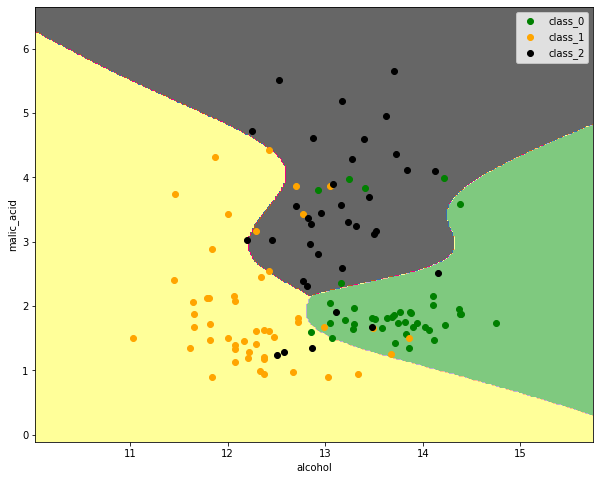

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()